In [2]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Install torch geometric
import os
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html


In [ ]:
# Import packages
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import spatial
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import sklearn.metrics

import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, SAGEConv, GATConv
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import networkx as nx

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

In [ ]:
# Import dataset
data_complete = pd.read_csv('/content/drive/MyDrive/CS570/Project/clean_mv_dataset.csv')
data = data_complete.iloc[:1000]

# Drop target
features = data.drop(['mech_expire_flag'], axis=1)

# Target
targets = data['mech_expire_flag']

# Load similarities
with open('/content/drive/MyDrive/CS570/Project/similarities_95.json') as json_file:
    sim_85 = json.load(json_file)

NameError: ignored

In [ ]:
# Normalize dataset

norm_cols = ['admission_age', 'hours_hosp_to_icu', 'hours_icu_to_mv', 'elixhauser_vanwalraven',
'oasis', 'lods', 'sapsii', 'sofa', 'heartrate_min', 'heartrate_max', 'heartrate_mean', 'sysbp_min',
'sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max', 'diasbp_mean', 'meanbp_min', 'meanbp_max',
'meanbp_mean', 'resprate_min', 'resprate_max', 'resprate_mean', 'tempc_min', 'tempc_max', 'tempc_mean',
'spo2_min', 'spo2_max', 'spo2_mean', 'bicarbonate_min', 'bicarbonate_max', 'creatinine_min',
'creatinine_max', 'chloride_min', 'chloride_max', 'glucose_min', 'glucose_max', 'hematocrit_min', 
'hematocrit_max', 'hemoglobin_min', 'hemoglobin_max', 'platelet_min', 'platelet_max', 'potassium_min',
'potassium_max', 'sodium_min', 'sodium_max', 'bun_min', 'bun_max', 'wbc_min', 'wbc_max']

scaler = MinMaxScaler()
features[norm_cols] = pd.DataFrame(scaler.fit_transform(features[norm_cols].values), columns=norm_cols, index=features.index)

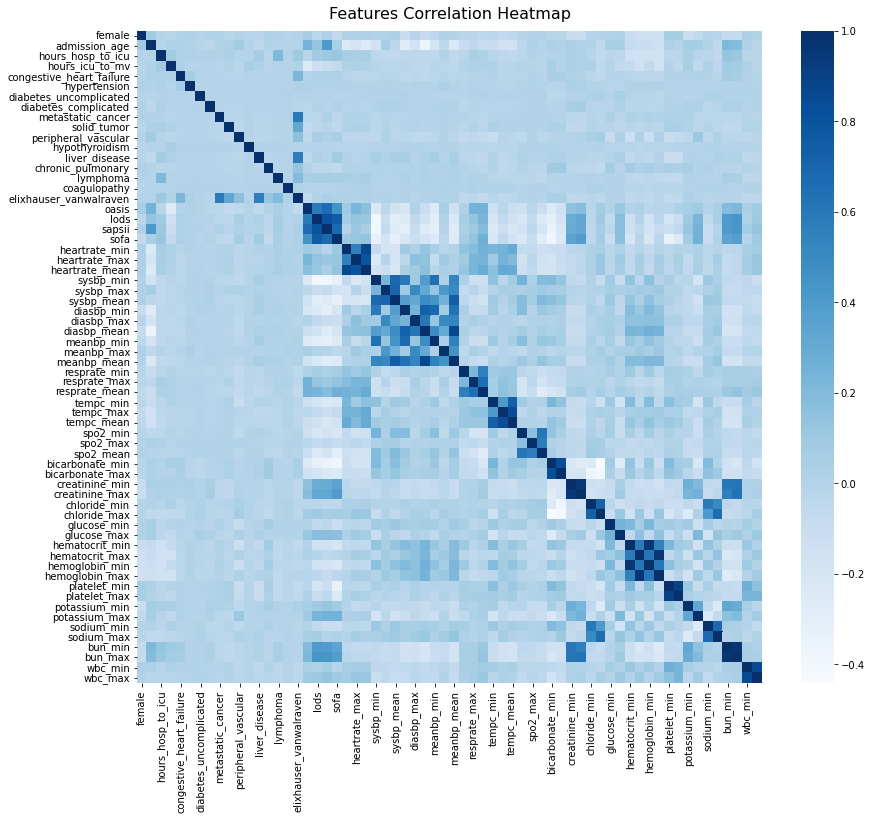

In [ ]:
# Visualize correlation
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(data_complete.drop(['mech_expire_flag'], axis=1).corr(), cmap='Blues')
heatmap.set_title('Features Correlation Heatmap', fontdict={'fontsize':16}, pad=12);

In [ ]:
# Create edges
edges_list = []
for pair in sim_85.keys():
  edge = list(tuple(map(int, pair.split('(')[1].split(')')[0].split(','))))
  un_edge = [edge[1], edge[0]]
  edges_list.append(edge)
  edges_list.append(un_edge)

In [ ]:
# Create masks
mask = np.ones((1000,), dtype=bool)
indices = np.random.randint(1000, size=200)
mask[indices] = False
train_mask = torch.tensor(mask, dtype=torch.bool)
test_mask = torch.tensor(~mask, dtype=torch.bool)

In [ ]:
# Construct graph
edge_index = torch.tensor(np.transpose(np.array(edges_list)), dtype=torch.long)
x = torch.tensor(np.array(features), dtype=torch.float)
y = torch.tensor(np.array(targets), dtype=torch.long)
graph = Data(x=x, edge_index=edge_index, y=y, num_classes=2, train_mask=train_mask, test_mask=test_mask)

In [ ]:
graph

Data(x=[1000, 64], edge_index=[2, 19484], y=[1000], num_classes=2, train_mask=[1000], test_mask=[1000])

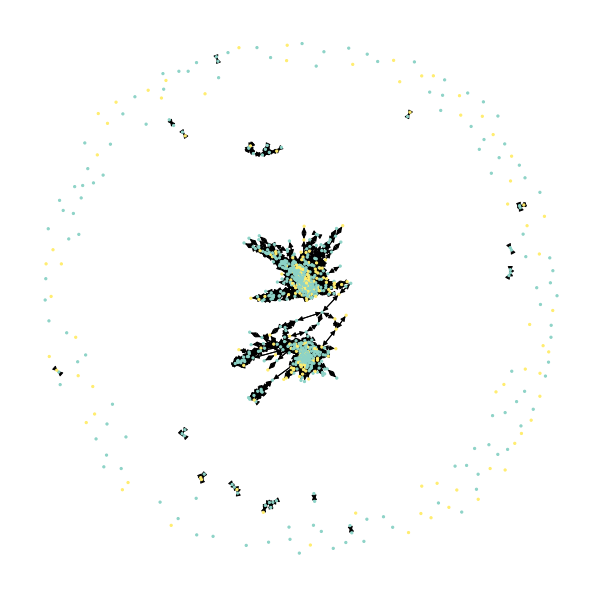

In [ ]:
# Visualize data
vis = pyg_utils.convert.to_networkx(graph)
node_labels = graph.y.numpy()
plt.figure(figsize=(8,8))
nx.draw(vis, cmap=plt.get_cmap('Set3'), node_color=node_labels, node_size=5, linewidths=1)
plt.show()

In [ ]:
dataset = graph

In [ ]:
# Define model

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(dataset.num_node_features, 16)
        self.conv2 = GATConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
# Train model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model.train()

train_loss = []

for epoch in range(1000):
  optimizer.zero_grad()
  out = model(data)
  loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  epoch_loss = loss.item() * data.train_mask.sum().item()
  nodes = data.train_mask.sum().item()
  train_loss.append(epoch_loss/nodes)

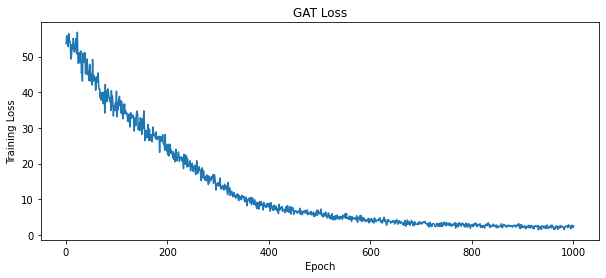

In [ ]:
# Visualize loss
plt.figure(figsize=(10,4))
plt.plot(list(range(1,1001)),train_loss)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("GAT Loss")
plt.show()

In [ ]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
accuracy = sklearn.metrics.confusion_matrix(data.y[data.test_mask], pred[data.test_mask])
auc = sklearn.metrics.roc_auc_score(data.y[data.test_mask], pred[data.test_mask])
print(f'Accuracy: {acc:.4f}')
print(accuracy)
print(auc)

Accuracy: 0.6686
[[114   5]
 [ 53   3]]
0.5057773109243698
